# 卷积神经网络：一步一步

欢迎来到课程 4 的第一个作业！ 在本作业中，您将在 numpy 中实现卷积 (CONV) 和池化 (POOL) 层，包括前向传播和（可选）反向传播。

**符号**:
- 上标 $[l]$ 表示  $l^{th}$ 层的一个对象. 
    - 示例：$a^{[4]}$ 是 $4^{th}$ 层激活。 $W^{[5]}$ 和 $b^{[5]}$ 是 $5^{th}$ 层参数。


- 上标 $(i)$ 表示来自 $i^{th}$ 示例的对象。
    - 示例：$x^{(i)}$ 是 $i^{th}$ 训练示例输入。
    
    
- 下标 $i$ 表示向量的 $i^{th}$ 项。
    - 示例：$a^{[l]}_i$ 表示 $l$ 层中激活的 $i^{th}$ 条目，假设这是一个全连接（FC）层。
    
    
- $n_H$、$n_W$ 和 $n_C$ 分别表示给定层的高度、宽度和通道数。 如果要引用特定层$l$，也可以写成$n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$。
- $n_{H_{prev}}$, $n_{W_{prev}}$ 和 $n_{C_{prev}}$ 分别表示前一层的高度、宽度和通道数。如果引用特定层 $l$，这也可以表示为 $n_H^{[l-1]}$、$n_W^{[l-1]}$、$n_C^{[l-1]}$。

我们假设您已经熟悉“numpy”和/或已经完成了以前的专业课程。 让我们开始吧！

## 1 - Packages

让我们首先导入您在此任务期间需要的所有包。
- [numpy](www.numpy.org) 是使用 Python 进行科学计算的基础包。
- [matplotlib](http://matplotlib.org) 是一个在 Python 中绘制图形的库。
- np.random.seed(1) 用于保持所有随机函数调用一致。 它将帮助我们为您的作品评分。

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - 作业大纲

您将实现卷积神经网络的构建块！ 您将实现的每个功能都有详细的说明，将引导您完成所需的步骤：

- 卷积函数，包括：
     - 零填充
     - 卷积窗口
     - 前向卷积
     - 向后卷积（可选）
- 池化功能，包括：
     - 向前汇集
     - 创建面具
     - 分配价值
     - 向后汇集（可选）
    
本笔记本将要求您在 `numpy` 中从头开始实现这些功能。 在下一个笔记本中，您将使用这些函数的 TensorFlow 等效项来构建以下模型：

<img src="images/model.png" style="width:800px;height:300px;">

**注意** 对于每个前向函数，都有其对应的后向等效函数。 因此，在前向模块的每一步，您都会将一些参数存储在缓存中。 这些参数用于在反向传播期间计算梯度。

## 3 - 卷积神经网络

尽管编程框架使卷积易于使用，但它们仍然是深度学习中最难理解的概念之一。 卷积层将输入体积转换为不同大小的输出体积，如下所示。

<img src="images/conv_nn.png" style="width:350px;height:200px;">

在这一部分中，您将构建卷积层的每一步。 您将首先实现两个辅助函数：一个用于零填充，另一个用于计算卷积函数本身。

### 3.1 - 零填充

零填充在图像边界周围添加零：

<img src="images/PAD.png" style="width:600px;height:400px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Zero-Padding**<br> Image (3 channels, RGB) with a padding of 2. </center></caption>

填充的主要好处如下：

- 它允许您使用 CONV 层，而不必缩小体积的高度和宽度。这对于构建更深的网络很重要，否则高度/宽度会随着您进入更深的层而缩小。一个重要的特殊情况是“相同”卷积，其中高度/宽度在一层之后完全保留。

- 它可以帮助我们将更多信息保留在图像的边缘。如果没有填充，下一层的值很少会受到作为图像边缘的像素的影响。

**Exercise**：实现以下函数，用零填充一批示例 X 的所有图像。 [使用 np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html)。请注意，如果要填充形状为 $(5,5,5,5,5)$ 的数组“a”，第 2 维使用 `pad = 1`，第 4 维使用 `pad = 3`并且`pad = 0` 剩下的，你会这样做：
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), 'constant', constant_values = (..,..))
```

In [15]:
# 分级功能：zero_pad

def zero_pad(X, pad):
    """
     用零填充数据集 X 的所有图像。填充应用于图像的高度和宽度，
     如图 1 所示。
    
     论点：
     X - python numpy 形状数组 (m, n_H, n_W, n_C) 表示一批 m 图像
     pad -- 整数，每个图像在垂直和水平维度上的填充量
    
     返回值：
     X_pad -- 形状的填充图像 (m, n_H + 2*pad, n_W + 2*pad, n_C)
     """
    
    ### START CODE HERE ### (≈ 1 line)
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    
    ### END CODE HERE ###
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


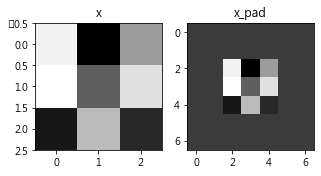

In [16]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

**Expected Output**:

<table>
    <tr>
        <td>
            **x.shape**:
        </td>
        <td>
           (4, 3, 3, 2)
        </td>
    </tr>
        <tr>
        <td>
            **x_pad.shape**:
        </td>
        <td>
           (4, 7, 7, 2)
        </td>
    </tr>
        <tr>
        <td>
            **x[1,1]**:
        </td>
        <td>
           [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
        </td>
    </tr>
        <tr>
        <td>
            **x_pad[1,1]**:
        </td>
        <td>
           [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
        </td>
    </tr>

</table>

### 3.2 - 单步卷积

在这一部分中，实现单步卷积，将过滤器应用于输入的单个位置。 这将用于构建一个卷积单元，它：

- 接受输入集
- 在输入的每个位置应用过滤器
- 输出另一个集（通常大小不同）

<img src="images/Convolution_schematic.gif" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : **Convolution operation**<br> with a filter of 2x2 and a stride of 1 (stride = amount you move the window each time you slide) </center></caption>

在计算机视觉应用程序中，左侧矩阵中的每个值对应一个像素值，我们通过将其值与原始矩阵逐元素相乘，然后将它们相加并添加偏差，将 3x3 滤波器与图像进行卷积 . 在练习的第一步中，您将实现单步卷积，对应于仅对其中一个位置应用过滤器以获得单个实值输出。

稍后在本笔记本中，您将将此函数应用于输入的多个位置以实现完整的卷积操作。 

**Exercise**: Implement conv_single_step(). [Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sum.html).


In [17]:
# 分级功能：conv_single_step

def conv_single_step(a_slice_prev, W, b):
    """
    在前一层的输出激活的单个切片 (a_slice_prev) 上应用由参数 W 定义的过滤器。
    
    Arguments:
    a_slice_prev -- 形状 (f, f, n_C_prev) 的输入数据切片
    W -- 窗口中包含的权重参数 - 形状矩阵 (f, f, n_C_prev)
    b -- 窗口中包含的偏置参数 - 形状矩阵 (1, 1, 1)
    
    Returns:
    Z -- 一个标量值，在输入数据的切片 x 上对滑动窗口 (W, b) 进行卷积的结果
    """

    ### START CODE HERE ### (≈ 2 lines of code)
    # a_slice_prev 和 W 之间的元素乘积。暂时不要添加偏差。
    s = np.multiply(a_slice_prev,W)
    # 对卷积 s 的所有项求和。
    Z = np.sum(s)
    # 将偏差 b 添加到 Z。将 b 转换为 float()，以便 Z 产生一个标量值。
    Z = Z + float(b)
    ### END CODE HERE ###

    return Z

In [5]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.99908945068


**Expected Output**:
<table>
    <tr>
        <td>
            **Z**
        </td>
        <td>
            -6.99908945068
        </td>
    </tr>

</table>

### 3.3 - 卷积神经网络 - 向前传播

在前向传递中，您将采用许多过滤器并将它们与输入进行卷积。 每个“卷积”都会为您提供 2D 矩阵输出。 然后，您将堆叠这些输出以获得 3D 体积：

<center>
<video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

**练习**：实现下面的函数以在输入激活 A_prev 上卷积过滤器 W。 该函数将输入 A_prev、前一层的激活输出（对于 m 个输入的批次）、用 W 表示的 F 个过滤器/权重和用 b 表示的偏置向量，其中每个过滤器都有自己的（单个）偏置。 最后，您还可以访问包含步幅和填充的超参数字典。

**示意**: 
1. 要在矩阵“a_prev”（形状 (5,5,3)）的左上角选择一个 2x2 切片，您可以：
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
当您使用您将定义的 `start/end` 索引在下面定义 `a_slice_prev` 时，这将很有用。
2. 要定义 a_slice，您首先需要定义它的角 `vert_start`、`vert_end`、`horiz_start` 和 `horiz_end`。 此图可能有助于您了解如何在下面的代码中使用 h、w、f 和 s 定义每个角。

<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">
<caption><center> <u> <font color='purple'> **图形 3** </u><font color='purple'>  : **使用垂直和水平开始/结束定义切片（使用 2x2 过滤器）** <br> 此图仅显示单个通道。 </center></caption>


**提醒**:
将卷积的输出形状与输入形状相关联的公式是：
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{卷积所用的过滤器数量}$$

在这个练习中，我们不会担心向量化，而是会使用 for 循环来实现所有内容。

In [19]:
# 分级功能：conv_forward

def conv_forward(A_prev, W, b, hparameters):
    """
    实现卷积函数的前向传播
    
    Arguments:
    A_prev -- 上一层的输出激活，numpy 数组形状(m, n_H_prev, n_W_prev, n_C_prev)
    W -- 权重, numpy 数组形状 (f, f, n_C_prev, n_C)
    b -- 偏差, numpy 数组形状 (1, 1, 1, n_C)
    超参 -- python 字典 包含 "步长" 和 "填充"
        
    返回值:
    Z -- 卷积输出, numpy数组的形状(m, n_H, n_W, n_C)
    cache -- 返回conv_backward()函数。需要的变量值的缓存
    """
    
    ### START CODE HERE ###
    # 从A_prev 的形状 取出 尺寸(≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # 从 W's shape 的形状 取出 尺寸(≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # 从 "hparameters"  取出 内容(≈2 lines)
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    #使用上面给出的公式计算 CONV 输出体积的尺寸。 提示：使用 int() 来设置。 （≈2 行）
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    # 用零初始化输出 Z。 (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # 通过填充 A_prev 创建 A_prev_pad
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                               # 遍历这批训练样本
        a_prev_pad = A_prev_pad[i]                     # 选择第 i 个训练示例的填充激活
        for h in range(n_H):                           # 在输出卷积的垂直轴上循环
            for w in range(n_W):                       # 在输出卷积的横轴上循环
                for c in range(n_C):                   # 循环输出卷积的通道（= #filters）
                    
                    # 找到当前“切片”的角点（≈4 行）
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # 使用角来定义 a_prev_pad 的 (3D) 切片（参见单元格上方的提示）。 (≈1 行)
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # 将 (3D) 切片与正确的滤波器 W 和偏置 b 进行卷积，以获得一个输出神经元。 (≈1 行)
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
                                        
    ### END CODE HERE ###
    
    # 确保输出的形状是对的
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # 为了后面的反向传播，现在保存一些值到缓存内。
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [7]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.0489952035289
Z[3,2,1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


**Expected Output**:

<table>
    <tr>
        <td>
            **Z's mean**
        </td>
        <td>
            0.0489952035289
        </td>
    </tr>
    <tr>
        <td>
            **Z[3,2,1]**
        </td>
        <td>
            [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
        </td>
    </tr>
    <tr>
        <td>
            **cache_conv[0][1][2][3]**
        </td>
        <td>
            [-0.20075807  0.18656139  0.41005165]
        </td>
    </tr>

</table>


最后，CONV 层还应该包含一个激活，在这种情况下，我们将添加以下代码行：

```python
# 卷积窗口以取回一个输出神经元
Z[i, h, w, c] = ...
# 申请激活
A[i, h, w, c] = activation(Z[i, h, w, c])
```

你不需要在这里做。 


## 4 - 池化层

池化（POOL）层减少了输入的高度和宽度。 它有助于减少计算量，并有助于使特征检测器对其在输入中的位置更加不变。 两种类型的池化层是： 

- 最大池化层：在输入上滑动一个 ($f, f$) 窗口并将窗口的最大值存储在输出中。

- 平均池化层：在输入上滑动一个 ($f, f$) 窗口并将窗口的平均值存储在输出中。

<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

这些池化层没有用于反向传播训练的参数。 但是，它们具有超参数，例如窗口大小 $f$。 这指定了您将计算最大值或平均值的 fxf 窗口的高度和宽度。

### 4.1 - 前向池化
现在，您将在同一个函数中实现 MAX-POOL 和 AVG-POOL。

**训练**: 实现池化层的前向传递。 按照下面评论中的提示进行操作。<br>
**提醒**:
由于没有填充，将池的输出形状绑定到输入形状的公式是：
$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$
$$ n_C = n_{C_{prev}}$$

In [20]:
# 分级功能：pool_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    实现池化层的前向传递
    
     论据：
     A_prev -- 输入数据，numpy 形状数组 (m, n_H_prev, n_W_prev, n_C_prev)
     hparameters - 包含“f”和“stride”的python字典
     mode -- 您想使用的池化模式，定义为字符串（“max”或“average”）
    
     返回:
     A -- 池层的输出，一个形状为 (m, n_H, n_W, n_C) 的 numpy 数组
     cache -- 用于池化层后向传递的缓存，包含输入和 h 参数
    """
    
    # 从输入形状中检索尺寸
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # 从“hparameters”中检索超参数
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # 定义输出的维度
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # 初始化输出矩阵 A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    ### START CODE HERE ###
    for i in range(m):                         # 循环训练集
        for h in range(n_H):                     # 在输出卷积的垂直轴方向循环
            for w in range(n_W):                 # 在输出卷积的横轴方向循环
                for c in range (n_C):            # 循环输出卷积的通道
                    
                    # 找到当前切片的4个角(≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # 使用角点定义 A_prev 的第 i 个训练示例、通道 c 上的当前切片。 (≈1 行)
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # 计算切片上的池化操作。 使用 if 语句来区分模式。 使用 np.max/np.mean。
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    ### END CODE HERE ###
    
    # 将输入和 h 参数存储在 pool_backward() 的“缓存”中
    cache = (A_prev, hparameters)
    
    # 确保您的输出形状正确
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [21]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]

mode = average
A = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


**Expected Output:**
<table>
    <tr>
        <td>
            A  =
        </td>
        <td>
             [[[[ 1.74481176  0.86540763  1.13376944]]]<br>
            [[[ 1.13162939  1.51981682  2.18557541]]]]
        </td>
    </tr>
    <tr>
        <td>
            A  =
        </td>
        <td>
             [[[[ 0.02105773 -0.20328806 -0.40389855]]]<br>
            [[[-0.22154621  0.51716526  0.48155844]]]]
        </td>
    </tr>
</table>

恭喜！ 您现在已经实现了卷积网络所有层的前向传递。

这个笔记本的剩余部分是可选的，不会被评分。

## 5 - 卷积神经网络中的反向传播（可选/未分级）

在现代深度学习框架中，你只需要实现前向传递，而框架负责后向传递，因此大多数深度学习工程师不需要关心后向传递的细节。 卷积网络的反向传播很复杂。 但是，如果您愿意，您可以通过笔记本的这个可选部分来了解卷积网络中的反向传播是什么样的。

在之前的课程中，您实现了一个简单的（完全连接的）神经网络，您使用反向传播来计算与更新参数成本相关的导数。 同样，在卷积神经网络中，您可以计算相对于成本的导数以更新参数。 反向传播方程并非微不足道，我们在讲座中没有推导出它们，但我们在下面简要介绍了它们。

### 5.1 - 卷积层反向传播 

让我们从实现 CONV 层的反向传播开始。

#### 5.1.1 - 计算 dA:
这是针对某个过滤器 $W_c$ 和给定训练示例的成本计算 $dA$ 的公式：

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

其中$W_c$是一个过滤器，$dZ_{hw}$是一个标量，对应于conv层Z在第h行第w列的输出的代价梯度（对应于在第 第 i 步向左，第 j 步向下）。 请注意，每次更新 dA 时，我们将相同的过滤器 $W_c$ 乘以不同的 dZ。 我们这样做主要是因为在计算前向传播时，每个过滤器都由不同的 a_slice 点和求和。 因此，在计算 dA 的反向传播时，我们只是将所有 a_slices 的梯度相加。

在代码中，在适当的 for 循环中，此公式转换为：
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

#### 5.1.2 - 计算 dW:
这是计算关于损失的 $dW_c$（$dW_c$ 是一个滤波器的导数）的公式：

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

其中 $a_{slice}$ 对应于用于生成激活 $Z_{ij}$ 的切片。 因此，这最终为我们提供了 $W$ 相对于该切片的梯度。 由于它是相同的 $W$，我们只需将所有这些梯度相加即可得到 $dW$。

在代码中，在适当的 for 循环中，此公式转换为：
```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

#### 5.1.3 - 计算 db:

这是针对某个过滤器 $W_c$ 的成本计算 $db$ 的公式：

$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

正如您之前在基本神经网络中看到的，db 是通过对 $dZ$ 求和来计算的。 在这种情况下，您只是对 conv 输出 (Z) 相对于成本的所有梯度求和。

在代码中，在适当的 for 循环中，此公式转换为：
```python
db[:,:,:,c] += dZ[i, h, w, c]
```

**练习**：实现下面的`conv_backward`函数。 您应该总结所有训练示例、过滤器、高度和宽度。 然后，您应该使用上面的公式 1、2 和 3 计算导数。

In [10]:
def conv_backward(dZ, cache):
    """
    实现卷积函数的反向传播
    
     论据：
     dZ - 成本相对于卷积层输出的梯度 (Z)，numpy 形状数组 (m, n_H, n_W, n_C)
     cache -- conv_backward() 所需值的缓存，conv_forward() 的输出
    
     返回：
     dA_prev——成本相对于卷积层输入的梯度（A_prev），
                numpy 形状数组（m，n_H_prev，n_W_prev，n_C_prev）
     dW——成本相对于卷积层权重的梯度（W）
           numpy 形状数组 (f, f, n_C_prev, n_C)
     db -- 成本相对于 conv 层偏差的梯度 (b)
           numpy 形状数组 (1, 1, 1, n_C)
    """
    
    ### START CODE HERE ###
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [11]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 0.634770447265
dW_mean = 1.55726574285
db_mean = 7.83923256462


** Expected Output: **
<table>
    <tr>
        <td>
            **dA_mean**
        </td>
        <td>
            1.45243777754
        </td>
    </tr>
    <tr>
        <td>
            **dW_mean**
        </td>
        <td>
            1.72699145831
        </td>
    </tr>
    <tr>
        <td>
            **db_mean**
        </td>
        <td>
            7.83923256462
        </td>
    </tr>

</table>


## 5.2 Pooling layer - backward pass

Next, let's implement the backward pass for the pooling layer, starting with the MAX-POOL layer. Even though a pooling layer has no parameters for backprop to update, you still need to backpropagation the gradient through the pooling layer in order to compute gradients for layers that came before the pooling layer. 

### 5.2.1 Max pooling - backward pass  

Before jumping into the backpropagation of the pooling layer, you are going to build a helper function called `create_mask_from_window()` which does the following: 

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

As you can see, this function creates a "mask" matrix which keeps track of where the maximum of the matrix is. True (1) indicates the position of the maximum in X, the other entries are False (0). You'll see later that the backward pass for average pooling will be similar to this but using a different mask.  

**Exercise**: Implement `create_mask_from_window()`. This function will be helpful for pooling backward. 
Hints:
- [np.max()]() may be helpful. It computes the maximum of an array.
- If you have a matrix X and a scalar x: `A = (X == x)` will return a matrix A of the same size as X such that:
```
A[i,j] = True if X[i,j] = x
A[i,j] = False if X[i,j] != x
```
- Here, you don't need to consider cases where there are several maxima in a matrix.

In [12]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    
    ### START CODE HERE ### (≈1 line)
    mask = x == np.max(x)
    ### END CODE HERE ###
    
    return mask

In [13]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


**Expected Output:** 

<table> 
<tr> 
<td>

**x =**
</td>

<td>

[[ 1.62434536 -0.61175641 -0.52817175] <br>
 [-1.07296862  0.86540763 -2.3015387 ]]

  </td>
</tr>

<tr> 
<td>
**mask =**
</td>
<td>
[[ True False False] <br>
 [False False False]]
</td>
</tr>


</table>

Why do we keep track of the position of the max? It's because this is the input value that ultimately influenced the output, and therefore the cost. Backprop is computing gradients with respect to the cost, so anything that influences the ultimate cost should have a non-zero gradient. So, backprop will "propagate" the gradient back to this particular input value that had influenced the cost. 

### 5.2.2 - Average pooling - backward pass 

In max pooling, for each input window, all the "influence" on the output came from a single input value--the max. In average pooling, every element of the input window has equal influence on the output. So to implement backprop, you will now implement a helper function that reflects this.

For example if we did average pooling in the forward pass using a 2x2 filter, then the mask you'll use for the backward pass will look like: 
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

This implies that each position in the $dZ$ matrix contributes equally to output because in the forward pass, we took an average. 

**Exercise**: Implement the function below to equally distribute a value dz through a matrix of dimension shape. [Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ones.html)

In [14]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from shape (≈1 line)
    (n_H, n_W) = shape
    
    # Compute the value to distribute on the matrix (≈1 line)
    average = dz / (n_H * n_W)
    
    # Create a matrix where every entry is the "average" value (≈1 line)
    a = np.ones(shape) * average
    ### END CODE HERE ###
    
    return a

In [15]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[ 0.5  0.5]
 [ 0.5  0.5]]


**Expected Output**: 

<table> 
<tr> 
<td>
distributed_value =
</td>
<td>
[[ 0.5  0.5]
<br\> 
[ 0.5  0.5]]
</td>
</tr>
</table>

### 5.2.3 Putting it together: Pooling backward 

You now have everything you need to compute backward propagation on a pooling layer.

**Exercise**: Implement the `pool_backward` function in both modes (`"max"` and `"average"`). You will once again use 4 for-loops (iterating over training examples, height, width, and channels). You should use an `if/elif` statement to see if the mode is equal to `'max'` or `'average'`. If it is equal to 'average' you should use the `distribute_value()` function you implemented above to create a matrix of the same shape as `a_slice`. Otherwise, the mode is equal to '`max`', and you will create a mask with `create_mask_from_window()` and multiply it by the corresponding value of dZ.

In [16]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    
    ### START CODE HERE ###
    
    # Retrieve information from cache (≈1 line)
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                       # loop over the training examples
        # select training example from A_prev (≈1 line)
        a_prev = A_prev[i]
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        # Get the value a from dA (≈1 line)
                        da = dA[i, h, w, c]
                        # Define the shape of the filter as fxf (≈1 line)
                        shape = (f, f)
                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
                        
    ### END CODE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [17]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.145713902729
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.145713902729
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


**Expected Output**: 

mode = max:
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
**dA_prev[1,1] =** 
</td>
<td>
[[ 0.          0.        ] <br>
 [ 5.05844394 -1.68282702] <br>
 [ 0.          0.        ]]
</td>
</tr>
</table>

mode = average
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
**dA_prev[1,1] =** 
</td>
<td>
[[ 0.08485462  0.2787552 ] <br>
 [ 1.26461098 -0.25749373] <br>
 [ 1.17975636 -0.53624893]]
</td>
</tr>
</table>

### Congratulations !

Congratulation on completing this assignment. You now understand how convolutional neural networks work. You have implemented all the building blocks of a neural network. In the next assignment you will implement a ConvNet using TensorFlow.